# 🧪 Jet Tagging Hands-on Lab

Welcome to this hands-on lab! In this notebook, you'll work through a complete flow to train and deploy a machine learning model for **Jet Tagging** using `QKeras` and `hls4ml`.

### 📌 Note
This tutorial is **heavily based on code from the [`hls4ml-tutorial`](https://github.com/fastmachinelearning/hls4ml-tutorial) GitHub repository**, which is the implementation of the paper *Duarte, Javier, et al. "Fast inference of deep neural networks in FPGAs for particle physics." Journal of instrumentation 13.07 (2018): P07027.*

You're highly encouraged to explore more notebooks in that repository — they provide deeper insight into topics such as **hls4ml configuration**, **quantization searching**, and **workflow deployment on FPGA platforms**.

### 💡 Lab Goals:
- Load and preprocess the Jet Tagging dataset
- Build and quantize a model using QKeras
- Train and evaluate the quantized model
- Convert the model using `hls4ml`
- Compare predictions from QKeras vs HLS model (via C-simulation)

<!-- TODO: Insert Jet Tagging overview diagram here -->

# QKeras and hls4ml installation
## After installing packages using `pip install`, you need to **restart the runtime** to use the newly installed versions. 😊

In [27]:
!pip install qkeras
!pip install tensorflow==2.12.0
!pip install hls4ml==1.1.0

# 📂 Step 1: Load and Preprocess the Dataset

## In this step, we load a **jet classification dataset** from high-energy physics experiments.

Each data sample corresponds to a **jet** — a collimated spray of particles produced in high-energy collisions — and is described by **16 physics-motivated high-level features**. We'll also apply **normalization** to ensure the features are on a similar scale, which helps improve model convergence and umerical stability.

The task is to classify jets into **five categories** based on their origin:
- **Quark (q)**
- **Gluon (g)**
- **W boson**
- **Z boson**
- **Top quark (t)**

These categories represent different particle-level processes, and successful classification can help identify rare or interesting physics events.

<!-- TODO: Insert diagram of jet classification concept (optional) -->




In [28]:
from tensorflow.keras.utils import to_categorical
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
import numpy as np

%matplotlib inline
seed = 0
np.random.seed(seed)
import tensorflow as tf

tf.random.set_seed(seed)

### Fetch the jet tagging dataset from Open ML

In [29]:
data = fetch_openml('hls4ml_lhc_jets_hlf')
X, y = data['data'], data['target']

### Let's print some information about the dataset
Print the feature names and the dataset shape

In [30]:
print(data['feature_names'])
print(X.shape, y.shape)
print(X[:5])
print(y[:5])

['zlogz', 'c1_b0_mmdt', 'c1_b1_mmdt', 'c1_b2_mmdt', 'c2_b1_mmdt', 'c2_b2_mmdt', 'd2_b1_mmdt', 'd2_b2_mmdt', 'd2_a1_b1_mmdt', 'd2_a1_b2_mmdt', 'm2_b1_mmdt', 'm2_b2_mmdt', 'n2_b1_mmdt', 'n2_b2_mmdt', 'mass_mmdt', 'multiplicity']
(830000, 16) (830000,)
      zlogz  c1_b0_mmdt  c1_b1_mmdt  c1_b2_mmdt  c2_b1_mmdt  c2_b2_mmdt  \
0 -2.935125    0.383155    0.005126    0.000084    0.009070    0.000179   
1 -1.927335    0.270699    0.001585    0.000011    0.003232    0.000029   
2 -3.112147    0.458171    0.097914    0.028588    0.124278    0.038487   
3 -2.666515    0.437068    0.049122    0.007978    0.047477    0.004802   
4 -2.484843    0.428981    0.041786    0.006110    0.023066    0.001123   

   d2_b1_mmdt  d2_b2_mmdt  d2_a1_b1_mmdt  d2_a1_b2_mmdt  m2_b1_mmdt  \
0    1.769445    2.123898       1.769445       0.308185    0.135687   
1    2.038834    2.563099       2.038834       0.211886    0.063729   
2    1.269254    1.346238       1.269254       0.246488    0.115636   
3    0.966505  

As you saw above, the `y` target is an array of strings, e.g. \['g', 'w',...\] etc.
We need to make this a "One Hot" encoding for the training.
Then, split the dataset into training and validation sets

In [31]:
le = LabelEncoder()
y = le.fit_transform(y)
y = to_categorical(y, 5)
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(y[:5])

[[1. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 1. 0.]]


In [32]:
le.classes_

array(['g', 'q', 't', 'w', 'z'], dtype=object)

In [33]:
scaler = StandardScaler()
X_train_val = scaler.fit_transform(X_train_val)
X_test = scaler.transform(X_test)

## 🧠 Step 2: Define and Quantize the Model
We'll' use QKeras to build a quantized model.
QKeras is "Quantized Keras" for deep heterogeneous quantization of ML models.

https://github.com/google/qkeras

We'll use 3 hidden layers with 64, then 32, then 32 neurons. Each layer will use `relu` activation.
Add an output layer with 5 neurons (one for each class), then finish with Softmax activation.

The model will use fixed-point precision settings to prepare for FPGA deployment. We're using `QDense` layer instead of `Dense`, and `QActivation` instead of `Activation`. We're also specifying `kernel_quantizer = quantized_bits(6,0,0)`. This will use 6-bits (of which 0 are integer) for the weights. We also use the same quantization for the biases, and `quantized_relu(6,0)` for 6-bit ReLU activations.


In [34]:
# keras imports
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l1
from tensorflow.keras.layers import Activation

# qkeras imports
from qkeras.qlayers import QDense, QActivation
from qkeras.quantizers import quantized_bits, quantized_relu
from qkeras.autoqkeras.utils import print_qmodel_summary

In [35]:
model = Sequential()
model.add(
    QDense(
        64,
        input_shape=(16,),
        name='fc1',
        kernel_quantizer=quantized_bits(6, 0, alpha=1),
        bias_quantizer=quantized_bits(6, 0, alpha=1),
        kernel_initializer='lecun_uniform',
        kernel_regularizer=l1(0.0001),
    )
)
model.add(QActivation(activation=quantized_relu(6), name='relu1'))
model.add(
    QDense(
        32,
        name='fc2',
        kernel_quantizer=quantized_bits(6, 0, alpha=1),
        bias_quantizer=quantized_bits(6, 0, alpha=1),
        kernel_initializer='lecun_uniform',
        kernel_regularizer=l1(0.0001),
    )
)
model.add(QActivation(activation=quantized_relu(6), name='relu2'))
model.add(
    QDense(
        32,
        name='fc3',
        kernel_quantizer=quantized_bits(6, 0, alpha=1),
        bias_quantizer=quantized_bits(6, 0, alpha=1),
        kernel_initializer='lecun_uniform',
        kernel_regularizer=l1(0.0001),
    )
)
model.add(QActivation(activation=quantized_relu(6), name='relu3'))
model.add(
    QDense(
        5,
        name='output',
        kernel_quantizer=quantized_bits(6, 0, alpha=1),
        bias_quantizer=quantized_bits(6, 0, alpha=1),
        kernel_initializer='lecun_uniform',
        kernel_regularizer=l1(0.0001),
    )
)
model.add(Activation(activation='softmax', name='softmax'))

In [36]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 fc1 (QDense)                (None, 64)                1088      
                                                                 
 relu1 (QActivation)         (None, 64)                0         
                                                                 
 fc2 (QDense)                (None, 32)                2080      
                                                                 
 relu2 (QActivation)         (None, 32)                0         
                                                                 
 fc3 (QDense)                (None, 32)                1056      
                                                                 
 relu3 (QActivation)         (None, 32)                0         
                                                                 
 output (QDense)             (None, 5)                

In [37]:
print_qmodel_summary(model)

fc1                  u=64 quantized_bits(6,0,0,alpha=1) quantized_bits(6,0,0,alpha=1) 
relu1                quantized_relu(6,0)
fc2                  u=32 quantized_bits(6,0,0,alpha=1) quantized_bits(6,0,0,alpha=1) 
relu2                quantized_relu(6,0)
fc3                  u=32 quantized_bits(6,0,0,alpha=1) quantized_bits(6,0,0,alpha=1) 
relu3                quantized_relu(6,0)
output               u=5 quantized_bits(6,0,0,alpha=1) quantized_bits(6,0,0,alpha=1) 



# 🏋️ Step 3: Train the Quantized Model

We'll use Adam optimizer with categorical crossentropy loss.

The model isn't very complex, so this should just take a few minutes even on the CPU.

In [38]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss=['categorical_crossentropy'], metrics=['accuracy'])

model.fit(
    X_train_val,
    y_train_val,
    batch_size=1024,
    epochs=10,
    validation_split=0.25,
    shuffle=True
)

Epoch 1/10
487/487 [==============================] - 17s 25ms/step - loss: 1.4160 - accuracy: 0.4614 - val_loss: 1.1953 - val_accuracy: 0.6055
Epoch 2/10
487/487 [==============================] - 10s 21ms/step - loss: 1.1085 - accuracy: 0.6589 - val_loss: 1.0408 - val_accuracy: 0.6900
Epoch 3/10
487/487 [==============================] - 8s 17ms/step - loss: 0.9873 - accuracy: 0.7023 - val_loss: 0.9497 - val_accuracy: 0.7112
Epoch 4/10
487/487 [==============================] - 6s 13ms/step - loss: 0.9200 - accuracy: 0.7164 - val_loss: 0.9011 - val_accuracy: 0.7210
Epoch 5/10
487/487 [==============================] - 5s 10ms/step - loss: 0.8813 - accuracy: 0.7236 - val_loss: 0.8705 - val_accuracy: 0.7259
Epoch 6/10
487/487 [==============================] - 5s 10ms/step - loss: 0.8564 - accuracy: 0.7281 - val_loss: 0.8498 - val_accuracy: 0.7291
Epoch 7/10
487/487 [==============================] - 6s 12ms/step - loss: 0.8371 - accuracy: 0.7320 - val_loss: 0.8321 - val_accuracy: 0.73

### Check the value of weights
You can use `model_save_quantized_weights` to apply weight quantization.

This won't affect the inference result.

In [39]:
model.weights[0]

<tf.Variable 'fc1/kernel:0' shape=(16, 64) dtype=float32, numpy=
array([[-0.01166131,  0.22245498, -0.0377763 , ...,  0.03610557,
         0.29544067,  0.3590441 ],
       [-0.07509288, -0.20161793, -0.0095477 , ..., -0.08744581,
         0.29891306,  0.23850572],
       [-0.24732478,  0.32488054,  0.01886008, ...,  0.5407387 ,
         0.34540144, -0.2565809 ],
       ...,
       [ 0.00213178, -0.06184578, -0.18351525, ..., -0.12951742,
         0.13869327,  0.27782476],
       [ 0.20490868,  0.11849296,  0.03398565, ...,  0.07226276,
        -0.18073373, -0.19631541],
       [-0.29690644,  0.29246044,  0.2663288 , ..., -0.4217024 ,
        -0.27507466,  0.20839566]], dtype=float32)>

In [40]:
from qkeras.utils import load_qmodel, model_save_quantized_weights

model_save_quantized_weights(model)
model.weights[0]

... quantizing model


<tf.Variable 'fc1/kernel:0' shape=(16, 64) dtype=float32, numpy=
array([[ 0.     ,  0.21875, -0.03125, ...,  0.03125,  0.28125,  0.34375],
       [-0.0625 , -0.1875 ,  0.     , ..., -0.09375,  0.3125 ,  0.25   ],
       [-0.25   ,  0.3125 ,  0.03125, ...,  0.53125,  0.34375, -0.25   ],
       ...,
       [ 0.     , -0.0625 , -0.1875 , ..., -0.125  ,  0.125  ,  0.28125],
       [ 0.21875,  0.125  ,  0.03125, ...,  0.0625 , -0.1875 , -0.1875 ],
       [-0.3125 ,  0.28125,  0.28125, ..., -0.40625, -0.28125,  0.21875]],
      dtype=float32)>

### Quantized model saving and loading

In [41]:
model.save("jet_mlp.h5")
model = load_qmodel("jet_mlp.h5")

### Check performance
Check the accuracy and make a ROC curve

In [42]:
import itertools

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import auc, roc_curve




def plotRoc(fpr, tpr, auc, labels, linestyle, legend=True):
    for _i, label in enumerate(labels):
        plt.plot(
            tpr[label],
            fpr[label],
            label='{} tagger, AUC = {:.1f}%'.format(label.replace('j_', ''), auc[label] * 100.0),
            linestyle=linestyle,
        )
    plt.semilogy()
    plt.xlabel("Signal Efficiency")
    plt.ylabel("Background Efficiency")
    plt.ylim(0.001, 1)
    plt.grid(True)
    if legend:
        plt.legend(loc='upper left')
    plt.figtext(0.25, 0.90, 'hls4ml', fontweight='bold', wrap=True, horizontalalignment='right', fontsize=14)


def rocData(y, predict_test, labels):
    df = pd.DataFrame()

    fpr = {}
    tpr = {}
    auc1 = {}

    for i, label in enumerate(labels):
        df[label] = y[:, i]
        df[label + '_pred'] = predict_test[:, i]

        fpr[label], tpr[label], threshold = roc_curve(df[label], df[label + '_pred'])

        auc1[label] = auc(fpr[label], tpr[label])
    return fpr, tpr, auc1


def makeRoc(y, predict_test, labels, linestyle='-', legend=True):
    if 'j_index' in labels:
        labels.remove('j_index')

    fpr, tpr, auc1 = rocData(y, predict_test, labels)
    plotRoc(fpr, tpr, auc1, labels, linestyle, legend=legend)
    return predict_test

5188/5188 [==============================] - 12s 2ms/step
Accuracy: 0.7383373493975903


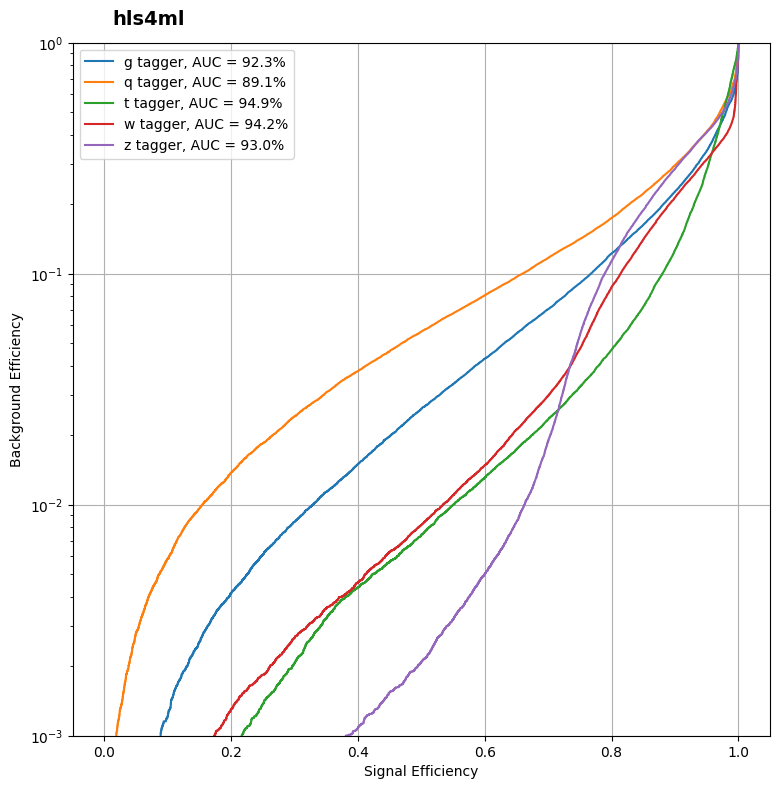

In [43]:
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

y_keras = model.predict(X_test)
print("Accuracy: {}".format(accuracy_score(np.argmax(y_test, axis=1), np.argmax(y_keras, axis=1))))
plt.figure(figsize=(9, 9))
_ = makeRoc(y_test, y_keras, le.classes_)

# 🔧 Step 4: HLS C++ conversion with hls4ml


Now we will go through the steps to convert the model we trained to a HLS C++ Design with hls4ml.

## Generate an hls4ml config & model

* The final HLS C++ design is controlled through a configuration dictionary.
* Can be created with `hls4ml.utils.config_from_keras_model`

### Arguments
- **Granularity***:
  - Default: `'model'`
  - Options: `'model'`, `'type'`, `'name'`
  - **Purpose**: Determines the verbosity of the config:
    - `'model'`: Applies changes to the entire model.
    - `'type'`: Affects all layers of the same type.
    - `'name'`: Configures layers separately for detailed tweaks.
- **Backend** *(str)*: Specifies the backend to use. e.g. "Vivado", "Vitis"
- **Default Precision** *(str)*:
  - Default: `'fixed<16,6>'`
  - **Note**: Must be explicit; `'auto'` is not allowed.
- **Default Reuse Factor** *(int)*:
  - Default: `1`

In [44]:
import hls4ml
from pprint import pprint

### Generate configuration with different granularity

In [45]:
config_model = hls4ml.utils.config_from_keras_model(model, granularity='model', backend='Vitis', default_precision='fixed<16,6>', default_reuse_factor=1)

print("\nConfiguration with granularity='model' ")
pprint(config_model)

Interpreting Sequential
Topology:
Layer name: fc1_input, layer type: InputLayer, input shapes: [[None, 16]], output shape: [None, 16]
Layer name: fc1, layer type: QDense, input shapes: [[None, 16]], output shape: [None, 64]
Layer name: relu1, layer type: Activation, input shapes: [[None, 64]], output shape: [None, 64]
Layer name: fc2, layer type: QDense, input shapes: [[None, 64]], output shape: [None, 32]
Layer name: relu2, layer type: Activation, input shapes: [[None, 32]], output shape: [None, 32]
Layer name: fc3, layer type: QDense, input shapes: [[None, 32]], output shape: [None, 32]
Layer name: relu3, layer type: Activation, input shapes: [[None, 32]], output shape: [None, 32]
Layer name: output, layer type: QDense, input shapes: [[None, 32]], output shape: [None, 5]
Layer name: softmax, layer type: Softmax, input shapes: [[None, 5]], output shape: [None, 5]

Configuration with granularity='model' 
{'Model': {'BramFactor': 1000000000,
           'Precision': {'default': 'fixed<16

In [46]:
config_name = hls4ml.utils.config_from_keras_model(model,
                          granularity='name',
                          backend='Vitis',
                          default_precision='fixed<16,6>',
                          default_reuse_factor=1
                          )

print("\nConfiguration with granularity='name' ")
pprint(config_name)

Interpreting Sequential
Topology:
Layer name: fc1_input, layer type: InputLayer, input shapes: [[None, 16]], output shape: [None, 16]
Layer name: fc1, layer type: QDense, input shapes: [[None, 16]], output shape: [None, 64]
Layer name: relu1, layer type: Activation, input shapes: [[None, 64]], output shape: [None, 64]
Layer name: fc2, layer type: QDense, input shapes: [[None, 64]], output shape: [None, 32]
Layer name: relu2, layer type: Activation, input shapes: [[None, 32]], output shape: [None, 32]
Layer name: fc3, layer type: QDense, input shapes: [[None, 32]], output shape: [None, 32]
Layer name: relu3, layer type: Activation, input shapes: [[None, 32]], output shape: [None, 32]
Layer name: output, layer type: QDense, input shapes: [[None, 32]], output shape: [None, 5]
Layer name: softmax, layer type: Softmax, input shapes: [[None, 5]], output shape: [None, 5]

Configuration with granularity='name' 
{'LayerName': {'fc1': {'Precision': {'accum': 'auto',
                             

In [47]:
config_type = hls4ml.utils.config_from_keras_model(model, granularity='type', backend='Vitis', default_precision='fixed<16,6>', default_reuse_factor=1)

print("\nConfiguration with granularity='type' ")
pprint(config_type)

Interpreting Sequential
Topology:
Layer name: fc1_input, layer type: InputLayer, input shapes: [[None, 16]], output shape: [None, 16]
Layer name: fc1, layer type: QDense, input shapes: [[None, 16]], output shape: [None, 64]
Layer name: relu1, layer type: Activation, input shapes: [[None, 64]], output shape: [None, 64]
Layer name: fc2, layer type: QDense, input shapes: [[None, 64]], output shape: [None, 32]
Layer name: relu2, layer type: Activation, input shapes: [[None, 32]], output shape: [None, 32]
Layer name: fc3, layer type: QDense, input shapes: [[None, 32]], output shape: [None, 32]
Layer name: relu3, layer type: Activation, input shapes: [[None, 32]], output shape: [None, 32]
Layer name: output, layer type: QDense, input shapes: [[None, 32]], output shape: [None, 5]
Layer name: softmax, layer type: Softmax, input shapes: [[None, 5]], output shape: [None, 5]

Configuration with granularity='type' 
{'LayerType': {'Activation': {'Precision': {'result': 'auto',
                     

In [48]:
# convert to hls design
hls_path = "jet_tagging_hls"
# for now we use granularity='name'
hls_model = hls4ml.converters.convert_from_keras_model(
    model, hls_config=config_name, backend='Vitis', output_dir=hls_path, part='xcu250-figd2104-2L-e'
)

Interpreting Sequential
Topology:
Layer name: fc1_input, layer type: InputLayer, input shapes: [[None, 16]], output shape: [None, 16]
Layer name: fc1, layer type: QDense, input shapes: [[None, 16]], output shape: [None, 64]
Layer name: relu1, layer type: Activation, input shapes: [[None, 64]], output shape: [None, 64]
Layer name: fc2, layer type: QDense, input shapes: [[None, 64]], output shape: [None, 32]
Layer name: relu2, layer type: Activation, input shapes: [[None, 32]], output shape: [None, 32]
Layer name: fc3, layer type: QDense, input shapes: [[None, 32]], output shape: [None, 32]
Layer name: relu3, layer type: Activation, input shapes: [[None, 32]], output shape: [None, 32]
Layer name: output, layer type: QDense, input shapes: [[None, 32]], output shape: [None, 5]
Layer name: softmax, layer type: Softmax, input shapes: [[None, 5]], output shape: [None, 5]
Creating HLS model


Let's visualise what we created. The model architecture is shown, annotated with the shape and data types

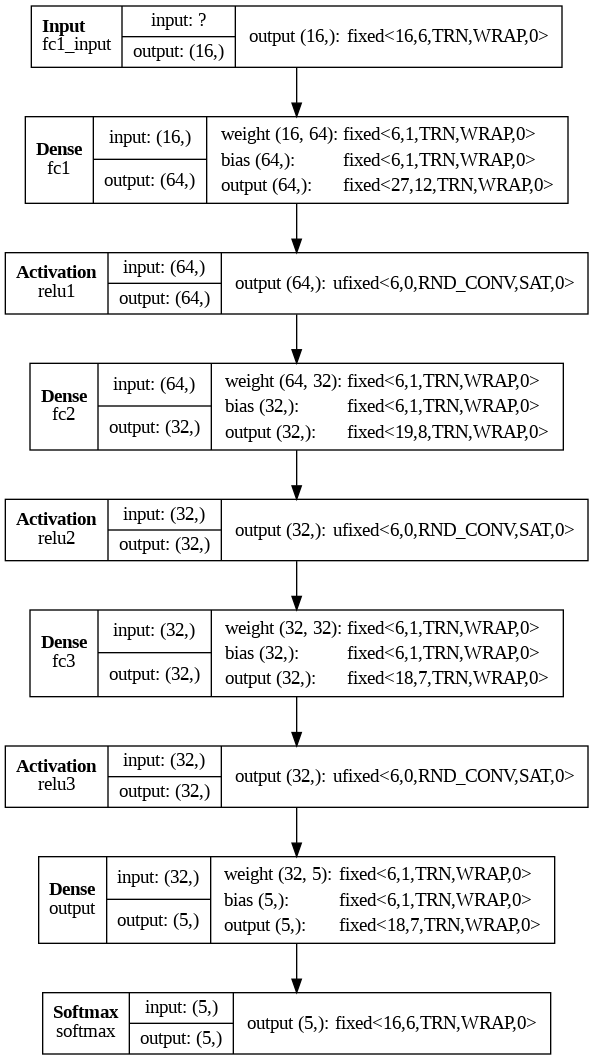

In [49]:
hls4ml.utils.plot_model(hls_model, show_shapes=True, show_precision=True, to_file=None)

## Compile, predict
Now we need to check that this model performance is still good. We compile the hls_model, and then use `hls_model.predict` to execute the FPGA firmware with bit-accurate emulation on the CPU.

In [50]:
hls_model.compile()
X_test = np.ascontiguousarray(X_test)
y_hls = hls_model.predict(X_test)
y_keras = model.predict(X_test)

# have a look at the prediction of the first batch
print(y_hls[0])
print(y_keras[0])

Writing HLS project
Done
5188/5188 [==============================] - 12s 2ms/step
[0.40039062 0.31152344 0.03222656 0.16601562 0.14648438]
[0.35802072 0.31105378 0.0297636  0.16184606 0.1393158 ]


## Compare
That was easy! Now let's see how the performance compares to Keras:

Keras  Accuracy: 0.7383373493975903
hls4ml Accuracy: 0.7383072289156627


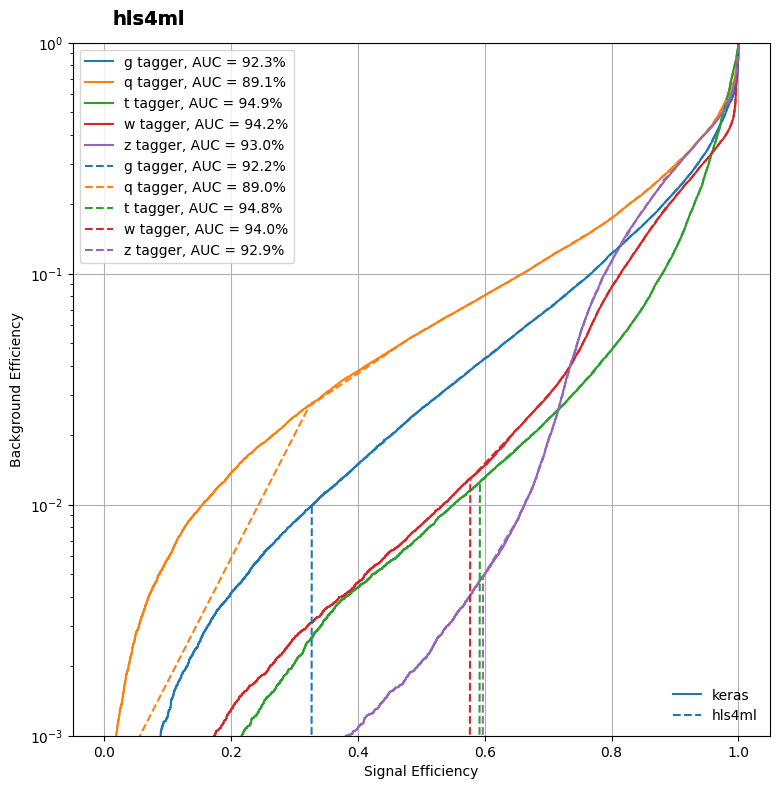

In [51]:
print("Keras  Accuracy: {}".format(accuracy_score(np.argmax(y_test, axis=1), np.argmax(y_keras, axis=1))))
print("hls4ml Accuracy: {}".format(accuracy_score(np.argmax(y_test, axis=1), np.argmax(y_hls, axis=1))))

fig, ax = plt.subplots(figsize=(9, 9))
_ = makeRoc(y_test, y_keras, le.classes_)
plt.gca().set_prop_cycle(None)  # reset the colors
_ = makeRoc(y_test, y_hls, le.classes_, linestyle='--')

from matplotlib.lines import Line2D

lines = [Line2D([0], [0], ls='-'), Line2D([0], [0], ls='--')]
from matplotlib.legend import Legend

leg = Legend(ax, lines, labels=['keras', 'hls4ml'], loc='lower right', frameon=False)
ax.add_artist(leg)

In [52]:
# save testbench files for hls project
SAVE_BATCH = 5 # use 5 batch of test data
X_test_batch = X_test[:SAVE_BATCH]
y_hls_batch = y_hls[:SAVE_BATCH]


#write x_test to tb_input_features.dat
INPUT_FILE = hls_path + '/tb_data/tb_input_features.dat'
np.savetxt(INPUT_FILE, X_test_batch.reshape(X_test_batch.shape[0], -1), delimiter=' ', fmt='%6f')

#write x_test to tb_input_features.dat
OUTPUT_FILE = hls_path + '/tb_data/tb_output_predictions.dat'
np.savetxt(OUTPUT_FILE, y_hls_batch.reshape(y_hls_batch.shape[0], -1), delimiter=' ', fmt='%6f')



In [53]:
!zip -r {hls_path}.zip {hls_path}

updating: jet_tagging_hls/ (stored 0%)
updating: jet_tagging_hls/project.tcl (deflated 49%)
updating: jet_tagging_hls/keras_model.keras (deflated 58%)
updating: jet_tagging_hls/vivado_synth.tcl (deflated 35%)
updating: jet_tagging_hls/myproject_bridge.cpp (deflated 67%)
updating: jet_tagging_hls/build_lib.sh (deflated 50%)
updating: jet_tagging_hls/hls4ml_config.yml (deflated 80%)
updating: jet_tagging_hls/myproject_test.cpp (deflated 71%)
updating: jet_tagging_hls/tb_data/ (stored 0%)
updating: jet_tagging_hls/tb_data/tb_input_features.dat (deflated 54%)
updating: jet_tagging_hls/tb_data/tb_output_predictions.dat (deflated 53%)
updating: jet_tagging_hls/build_prj.tcl (deflated 72%)
updating: jet_tagging_hls/firmware/ (stored 0%)
updating: jet_tagging_hls/firmware/defines.h (deflated 75%)
updating: jet_tagging_hls/firmware/ap_types/ (stored 0%)
updating: jet_tagging_hls/firmware/ap_types/ap_int_special.h (deflated 68%)
updating: jet_tagging_hls/firmware/ap_types/utils/ (stored 0%)
upda

### ⚠️ Step 6: HLS Synthesis (Requires Local Tools)

The following steps involve launching **HLS synthesis** (e.g., with Vivado HLS or Intel HLS). These tools **cannot be executed in Colab or Kaggle**.

Please export your project and run these steps on a **local machine** where the proper FPGA toolchain is installed.

Expected outputs may include resource usage reports, timing estimates, and latency cycles.